## Exercise 5.1: Bias-Variance Analysis

In this exercise we explore the bias and variance for different model classes given the simple target function $f(x) = \sin \pi x$. The model classes to investigate are:
  * Constant models: $h(x) = b$
  * Linear models: $h(x) = w x + b$
  * Polynomial models: $h(x) = w_d x^d + \ldots + w_2 x^2 + w_1 x + b $
  
You already know how to fit linear models. Polynomial models can be trained the same way if the dataset is augmented with the polynomial features first. Scikit-learn already offers a [convenient function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) to do this for you, but you are welcome to build your own solution for this.

**Task a): Model fitting.**
Fill in the functions below for augmenting datasets as well as fitting and evaluating the models to be investigated. Make sure to understand the dimensionality of input and output of each function.

In [11]:
import numpy as np

# We will use polynomials of degree 3 in this exercise
poly_degree = 3

# Shape guidelines
# X: (samples, features)
# y: (samples, targets)
# weights: (features, targets)

# A helper function to make sure that we fit and evaluate matrices of
# correct sizes. Remember that the first dimension always indicates
# the samples and the second the features or targets.
# Not all of these constraints are strictly necessary, but they will make
# your life easier when things go wrong.
def verify_shapes(X=None, y=None):
    if X is not None:
        assert X.ndim == 2 and X.shape[1] == 1
    if y is not None:
        assert y.ndim == 2 and y.shape[1] == 1
        if X is not None:
            assert y.shape[0] == X.shape[0]


# The ground-truth that we want to approximate.
# We only care about the domain [-1, 1], so no further preprocessing is required.
def target(X):
    verify_shapes(X)
    return np.sin(np.pi * X)


# Fit a constant model h(x) = b.
# Fitting only a bias reduces to the mean over the targets.
# Remember to keep the correct shape!
def fit_constant(X, y):
    verify_shapes(X, y)
    
    # Alternative: return y.mean(keepdims=True)
    return y.mean().reshape((-1, 1))
    

# Evaluate a constant model defined by its bias b.
def eval_constant(X, b):
    verify_shapes(X)
    print("b_in eval_constant",b)
    # The result should have the same number of samples as X
    return np.repeat(b, X.shape[0], axis=0)


# Add a bias "feature" to the data to get
# the augmented representation.
def add_bias(X):
    bias_column = np.ones((X.shape[0], 1)) 
    X_aug = np.hstack([bias_column, X])
    return X_aug

# Fit a linear model h(x) = wx + b.
# You can use the Moore-penrose pseudoinverse or the 
# least squares function in numpy.linalg.
# Remember to augment the dataset to include a column for the bias.
def fit_linear(X, y):
    verify_shapes(X, y)
    X_aug = add_bias(X)
    
    # Classic solution
    # Invert the data matrix
    inverse = np.linalg.inv(X_aug.T.dot(X_aug))
    
    # Moore-Penrose solution
    # weights = np.linalg.pinv(X_aug).dot(y)
    
    # Least squares solution
    # weights = np.linalg.lstsq(X_aug, y)[0]
    return inverse.dot(X_aug.T).dot(y)

# Evaluate a linear model defined by its weights w. Remember to augment X!
def eval_linear(X, w):
    verify_shapes(X)
    
    X_aug = add_bias(X)
    return np.dot(X_aug,w)
    #return X_aug.dot(w)

from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=True)
add_polynomials = poly_features.fit_transform

# Fit a polynomial model of degree 'poly_degree'.
# Augment the dataset with polynomial features and fit a linear model to it.
def fit_polynomial(X, y):
    verify_shapes(X, y)
    
    X_aug = add_polynomials(X)
    return np.linalg.pinv(X_aug).dot(y)

# Evaluate a polynomial model defined by its weights w.
# Remember to augment X!
def eval_polynomial(X, w):
    verify_shapes(X)
    
    X_aug = add_polynomials(X)
    return X_aug.dot(w)

Now that we can fit and evaluate these functions, we should create the datasets to evaluate the bias and variance of each model class. Since the bias-variance decomposition is defined as an expectation, we need to create sufficiently many datasets to get a good estimate.

---

** Task b): Model analysis.** Fit 100 models of each class to 100 datasets with only 5 samples each. Determine the average models and calculate the bias and variance of each class.

**Hint**: Remember the sample mean for the integrals: $\mathbb{E}[x] = \int x \ p(x) \ dx \approx \frac{1}{N} \sum_i^N x_i$

We provide you with plotting code for the visualization of the fitted and the average models below the code stub.

In [12]:
n_datasets = 100
n_samples = 5

# Bookkeeping
# We can store all the samples efficiently by using a 3d-array
X_all = np.zeros((n_datasets, n_samples, 1))
y_all = np.zeros((n_datasets, n_samples, 1))

# We also need to keep track of every model
constant_models = np.zeros((n_datasets, 1, 1))
linear_models = np.zeros((n_datasets, 2, 1))
polynomial_models = np.zeros((n_datasets, poly_degree + 1, 1))

# Sample the datasets uniformly for x in [-1, 1] and fit the models
# with the previously defined functions.
for i in range(n_datasets):
    # We could potentially sample X_all in one step, but to keep the
    # loop nice, we just do it one dataset at a time here
    X_all[i] = np.random.uniform(-1, 1, size=(n_samples, 1))
    
    # Calculate the targets
    y_all[i] = target(X_all[i])
    
    # Use our previously defined functions to fit one model
    constant_models[i] = fit_constant(X_all[i], y_all[i])
    linear_models[i] = fit_linear(X_all[i], y_all[i])
    polynomial_models[i] = fit_polynomial(X_all[i], y_all[i])

# Determine the average model for each class by
# averaging over the first axis
average_constant_model = np.mean(constant_models, axis=0)
average_linear_model = np.mean(linear_models, axis=0)
average_polynomial_model = np.mean(polynomial_models, axis=0)

# In order to evaluate the models over the ground truth, we form
# a linearly spaced grid in the target domain
X_eval = np.linspace(-1, 1, 200).reshape((-1, 1))
y_eval = target(X_eval)

# Calculate the bias and variance for each class with X_eval and y_eval

# For convenience, we write a function to do the decomposition,
# but it's perfectly fine to do it for each model class separately
def bias_variance_decomposition(models, average_model, eval_fct):
    # Evaluate all models
    # The matrix multiplication can also multiply stacks of matrices,
    # but we need to handle the dimensions correctly afterwards.
    # In this case, we will just take the mean, so we're fine.
    model_evals = eval_fct(X_eval, models.T)
    average_eval = eval_fct(X_eval, average_model)
    
    # Calculate the bias and variance
    # Due to the matrix multiplication above, this now
    # simple reduces to the mean squared error
    bias = np.mean((average_eval - y_eval)**2)
    variance = np.mean((model_evals - average_eval)**2)

    return bias, variance

# Calculating the values is now just a function call for each model class
bias_constant_models, variance_constant_models = \
    bias_variance_decomposition(constant_models,
                                average_constant_model,
                                eval_constant)

bias_linear_models, variance_linear_models = \
    bias_variance_decomposition(linear_models,
                                average_linear_model,
                                eval_linear)
    
bias_polynomial_models, variance_polynomial_models = \
    bias_variance_decomposition(polynomial_models,
                                average_polynomial_model,
                                eval_polynomial)
    
# Print the decomposition
bias_info = '''Bias:
    Constant models: {:.3f}
    Linear models: {:.3f}
    Polynomial models: {:.3f}'''
print(bias_info.format(float(bias_constant_models),
                                       float(bias_linear_models),
                                       float(bias_polynomial_models)))

variance_info = '''Variance:
    Constant models: {:.3f}
    Linear models: {:.3f}
    Polynomial models: {:.3f}'''
print(variance_info.format(float(variance_constant_models),
                                               float(variance_linear_models),
                                               float(variance_polynomial_models)))

b_in eval_constant [[[ 0.01571938 -0.17955296 -0.60031912  0.01732397 -0.21850176 -0.0727862
    0.37569644 -0.1187566  -0.44264009 -0.0579725  -0.24585113  0.1912118
    0.16128073 -0.36262686  0.42251222  0.1433578  -0.24169877  0.41670732
   -0.44907675  0.04489449  0.00131245  0.1644474  -0.16427097  0.5611003
    0.29956906  0.71736073  0.53669243  0.13642955 -0.23707748  0.22275302
    0.22894775  0.32114088  0.20844481  0.16689086  0.36544373 -0.19381355
   -0.32360513 -0.06170741 -0.15414198 -0.19953755 -0.60263688 -0.01578553
   -0.04612986 -0.58535071  0.17874218 -0.05872774  0.62569175 -0.35904694
   -0.39804234  0.30857532  0.29434885 -0.0736637   0.08739734  0.26627691
    0.26321867 -0.37217399 -0.02425245 -0.05986666 -0.34734571 -0.47347285
   -0.18826202  0.02909171  0.31857214 -0.35312525 -0.55525515 -0.70398216
    0.57320283  0.43753939  0.28402837 -0.38585982 -0.20730677  0.49171322
   -0.2373656   0.0862229   0.40745816 -0.60999581 -0.16433146 -0.02478855
    0.243

**Q 5.1.1: How and why do the bias and variance differ for the investigated model classes? How do they relate to over- and underfitting terminology? **

**Answer:** Bias should be decreasing and variance should be increasing in this order: constant, linear, polynomial. They differ because the added features allow the model to potentially fit this specific target function better, which on the same note increases the number of possible fits (and therefore the variance) given few datapoints. A high bias corresponds to underfitting, because the ground truth can never be matched correctly. A high variance might potentially lead to overfitting as the correct fit is just one of many possibilities.

** Q 5.2.2: So which model would you prefer and why? **

**Answer: ** The model with the lowest bias + variance. In most cases this should be the constant models, as the linear and polynomial models tends to have a high variance for only 5 samples per dataset. As we will see in the last exercise of this assignment, a regularized polynomial model can be better, though.

## Plotting Code

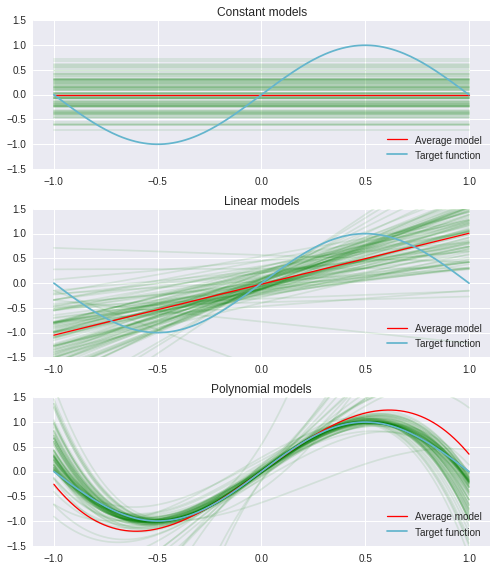

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
try: import seaborn as sns
except ImportError: pass
    
# Plotting
fig, axes = plt.subplots(3, 1, figsize=(7, 8))
axes[0].set_title('Constant models')
axes[1].set_title('Linear models')
axes[2].set_title('Polynomial models')

# Plot all the fitted models
for dataset in range(n_datasets):
    constant = constant_models[dataset].flatten()
    axes[0].plot((-1, 1), (constant, constant), c='g', alpha=0.1)
    
    weights = linear_models[dataset]
    axes[1].plot((-1, 1), (weights[0] - weights[1], weights[0] + weights[1]),
                 c='g', alpha=0.1)
    y_poly = eval_polynomial(X_eval, polynomial_models[dataset])
    if y_poly is not None:
        axes[2].plot(X_eval, y_poly, c='g', alpha=0.1)
    
# Plot the average models
if average_linear_model is not None:
    axes[1].plot((-1, 1), 
        (average_linear_model[0] - average_linear_model[1],
        average_linear_model[0] + average_linear_model[1]),
        c='r', lw=1.3, label='Average model')
if average_constant_model is not None:
    axes[0].plot((-1, 1), 
        (average_constant_model.flatten(), average_constant_model.flatten()),
        c='r', lw=1.3, label='Average model')
if average_polynomial_model is not None:
    axes[2].plot(X_eval, eval_polynomial(X_eval, average_polynomial_model), 
        c='r', lw=1.3, label='Average model')

for a in axes:
    a.plot(X_eval, target(X_eval), label='Target function')
    a.set_xlim((-1.1, 1.1))
    a.set_ylim((-1.5, 1.5))
    a.legend(loc='lower right')
    
fig.tight_layout()